## - Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn import utils
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,KFold,GroupKFold
import lightgbm as lgb
import gc

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ashrae-energy-prediction/sample_submission.csv
/kaggle/input/ashrae-energy-prediction/building_metadata.csv
/kaggle/input/ashrae-energy-prediction/weather_train.csv
/kaggle/input/ashrae-energy-prediction/weather_test.csv
/kaggle/input/ashrae-energy-prediction/train.csv
/kaggle/input/ashrae-energy-prediction/test.csv


## - Loading and Reducing Memory Usage of Data

In [2]:
data_path = "/kaggle/input/ashrae-energy-prediction/"

train_path = data_path + "train.csv"

building_path = data_path + "building_metadata.csv"

weather_train_path = data_path + "weather_train.csv"

In [3]:
train_data = pd.read_csv(train_path)

building_data = pd.read_csv(building_path)

weather_train_data = pd.read_csv(weather_train_path)

In [4]:
train_data = train_data.loc[train_data['meter'] == 0]
train_data = train_data.reset_index()

In [5]:
train_data.to_feather('train_data.feather')

building_data.to_feather('building_data.feather')

weather_train_data.to_feather('weather_train_data.feather')

In [6]:
train_data = pd.read_feather('train_data.feather')

building_data = pd.read_feather('building_data.feather')

weather_train_data = pd.read_feather('weather_train_data.feather')

In [7]:
def reduce_mem_usage(df, df_name):

    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:

        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2

    print('Memory usage of {} is reduced by {:.2f} %. Usage dropped from {:.2f} MB to {:.2f} MB.'.format(df_name, (100 * (start_mem - end_mem) / start_mem), start_mem, end_mem))
    
    return df


In [8]:
train_data = reduce_mem_usage(train_data, 'Train Data')

building_data = reduce_mem_usage(building_data, 'Building Data')

weather_train_data = reduce_mem_usage(weather_train_data, 'Weather Train Data')

Memory usage of Train Data is reduced by 67.43 %. Usage dropped from 460.09 MB to 149.85 MB.
Memory usage of Building Data is reduced by 73.88 %. Usage dropped from 0.07 MB to 0.02 MB.
Memory usage of Weather Train Data is reduced by 73.06 %. Usage dropped from 9.60 MB to 2.59 MB.


In [9]:
# merge data
train = train_data.merge(building_data, on='building_id', how='left')
train = train.merge(weather_train_data, on=['site_id', 'timestamp'], how='left')

In [10]:
def breakdown_timestamp(dataframe):
    
    dataframe['timestamp']= pd.to_datetime(dataframe['timestamp'])

    dataframe['hour']= np.uint8(dataframe['timestamp'].dt.hour)
    
    dataframe['day']= np.uint16(dataframe['timestamp'].dt.day)
    dataframe['dayofweek']= np.uint8(dataframe['timestamp'].dt.dayofweek)
    dataframe['dayofyear']= np.uint16(dataframe['timestamp'].dt.dayofyear)

    dataframe['month']= np.uint8(dataframe['timestamp'].dt.month)

    dataframe['year']= np.uint16(dataframe['timestamp'].dt.year)
    
    return dataframe

In [11]:
train = breakdown_timestamp(train)

## - Applying Log Transformation to 'Meter Reading and 'Square Feet'

In [12]:
train['meter_reading'] = np.log1p(train['meter_reading'])

In [13]:
train['square_feet'] = np.log1p(train['square_feet'])

# Feature Engineering

1. Removing rows with zero meter readings as they may indicate an innacurate or unavailable reading.
2. Setting a threshold limit to drop columns with more than 50 % missing values.
3. Filling In missing values using column median.
4. Adding new features.
5. Encoding categorical data.

## Removing Zero Meter Readings

In [14]:
zero_meter_readings = list(train[train['meter_reading'] == 0].index)
train.drop(zero_meter_readings, axis = 0, inplace = True)

In [15]:
print('New Shape of Train Data:',train.shape)

New Shape of Train Data: (11530741, 23)


## Dropping Columns with More than 50 % Missing Values

In [16]:
threshold = len(train) * 0.5
train.dropna(axis=1, thresh = threshold, inplace = True)

In [17]:
print('New Shape of Train Data:',train.shape)

New Shape of Train Data: (11530741, 21)


## Filling Missing Values

In [18]:
train['cloud_coverage'].fillna(train['cloud_coverage'].median(), inplace=True)
train['sea_level_pressure'].fillna(train['sea_level_pressure'].median(), inplace=True)
train['precip_depth_1_hr'].fillna(train['precip_depth_1_hr'].median(), inplace=True)
train['wind_direction'].fillna(train['wind_direction'].median(), inplace=True)
train['wind_speed'].fillna(train['wind_speed'].median(), inplace=True)
train['dew_temperature'].fillna(train['dew_temperature'].median(), inplace=True)
train['air_temperature'].fillna(train['air_temperature'].median(), inplace=True)

In [19]:
train.isnull().sum() / len(train)

index                 0.0
building_id           0.0
meter                 0.0
timestamp             0.0
meter_reading         0.0
site_id               0.0
primary_use           0.0
square_feet           0.0
air_temperature       0.0
cloud_coverage        0.0
dew_temperature       0.0
precip_depth_1_hr     0.0
sea_level_pressure    0.0
wind_direction        0.0
wind_speed            0.0
hour                  0.0
day                   0.0
dayofweek             0.0
dayofyear             0.0
month                 0.0
year                  0.0
dtype: float64

## Adding New Features

In [20]:
train['season'] = train['timestamp'].apply(lambda x: 'Spring' if x.month==3 or x.month==4 or x.month==5 else 
                                                  'Summer' if x.month==6 or x.month==7 or x.month==8 else 
                                                  'Autumn' if x.month==9 or x.month==10 or x.month==11 else 
                                                  'Winter')

train['isDayTime'] = train['timestamp'].apply(lambda x: 1 if x.hour >=6 and x.hour <=18 else 0)

In [21]:
train.head()

,index,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,...,wind_direction,wind_speed,hour,day,dayofweek,dayofyear,month,year,season,isDayTime
45,45,46,0,2016-01-01,3.993413,0,Retail,9.110078,25.000000,6.0,...,0.0,0.000000,0,1,4,1,1,2016,Winter,0
72,72,74,0,2016-01-01,3.784219,0,Parking,12.867830,25.000000,6.0,...,0.0,0.000000,0,1,4,1,1,2016,Winter,0
91,91,93,0,2016-01-01,3.978196,0,Office,10.415443,25.000000,6.0,...,0.0,0.000000,0,1,4,1,1,2016,Winter,0
103,103,105,0,2016-01-01,3.190624,1,Education,10.832181,3.800781,2.0,...,240.0,3.099609,0,1,4,1,1,2016,Winter,0
104,104,106,0,2016-01-01,0.318163,1,Education,8.589514,3.800781,2.0,...,240.0,3.099609,0,1,4,1,1,2016,Winter,0


## Encoding categorical data

In [22]:
categorical_features = ['primary_use', 'season']

In [23]:
encoder = preprocessing.LabelEncoder()

for i in categorical_features:
    
    train[i] = encoder.fit_transform(train[i])
    
print (train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11530741 entries, 45 to 12060909
Data columns (total 23 columns):
 #   Column              Dtype   
---  ------              -----   
 0   index               int32   
 1   building_id         int16   
 2   meter               int8    
 3   timestamp           category
 4   meter_reading       float32 
 5   site_id             int8    
 6   primary_use         int64   
 7   square_feet         float64 
 8   air_temperature     float16 
 9   cloud_coverage      float16 
 10  dew_temperature     float16 
 11  precip_depth_1_hr   float16 
 12  sea_level_pressure  float16 
 13  wind_direction      float16 
 14  wind_speed          float16 
 15  hour                uint8   
 16  day                 uint16  
 17  dayofweek           uint8   
 18  dayofyear           uint16  
 19  month               uint8   
 20  year                uint16  
 21  season              int64   
 22  isDayTime           int64   
dtypes: category(1), float16(7), f

In [24]:
train.head()

,index,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,...,wind_direction,wind_speed,hour,day,dayofweek,dayofyear,month,year,season,isDayTime
45,45,46,0,2016-01-01,3.993413,0,11,9.110078,25.000000,6.0,...,0.0,0.000000,0,1,4,1,1,2016,3,0
72,72,74,0,2016-01-01,3.784219,0,8,12.867830,25.000000,6.0,...,0.0,0.000000,0,1,4,1,1,2016,3,0
91,91,93,0,2016-01-01,3.978196,0,6,10.415443,25.000000,6.0,...,0.0,0.000000,0,1,4,1,1,2016,3,0
103,103,105,0,2016-01-01,3.190624,1,0,10.832181,3.800781,2.0,...,240.0,3.099609,0,1,4,1,1,2016,3,0
104,104,106,0,2016-01-01,0.318163,1,0,8.589514,3.800781,2.0,...,240.0,3.099609,0,1,4,1,1,2016,3,0


# Features Selection


**Using LGBM to Select the Best Features that Actually Affect the Model Results**

In [25]:
train = train.drop(['timestamp'],axis=1)

**Reducing the Memory Usage Again**

In [26]:
reduced_train_data = reduce_mem_usage(train, 'Train Data')

Memory usage of Train Data is reduced by 34.67 %. Usage dropped from 824.74 MB to 538.83 MB.


**Creating Training and Testing Data for the Model to Work With**

In [27]:
x = reduced_train_data.drop(['meter_reading'],axis=1)

In [28]:
y = reduced_train_data['meter_reading']

**Running The Feature Selection Model**

In [29]:
parameters = {
    
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'subsample': 0.2,
    'learning_rate': 0.9,  # 0.3 #0.5 #0.6 
    'feature_fraction': 0.9, #0.5 #0.6 #0.8
    'bagging_fraction': 0.9, #0.8
    'alpha': 0.1,
    'lambda': 0.1,
    'num_leaves': 110, #110 #100 #150 large, but over-fitting
    'max_bin': 66,  #60 #50 # large,but slower,over-fitting
    'max_depth': 10, # deal with over-fitting
    'min_data_in_leaf': 30, # deal with over-fitting

}


kf = KFold(n_splits = 5, shuffle = True, random_state = 42)

models = []

for train_index, val_index in kf.split(x):
    train_x = x.iloc[train_index]
    val_x = x.iloc[val_index]
    train_y = y.iloc[train_index]
    val_y = y.iloc[val_index]
    lgb_train = lgb.Dataset(train_x, train_y)
    lgb_eval = lgb.Dataset(val_x, val_y)
    gbm = lgb.train(parameters,
                    lgb_train,
                    num_boost_round = 10, 
                    valid_sets = (lgb_train, lgb_eval),
                    early_stopping_rounds = 10,
                    verbose_eval = 10) 
    
    models.append(gbm)
    
gc.collect()

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.2 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.2 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.534159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 742
[LightGBM] [Info] Number of data points in the train set: 9224592, number of used features: 20
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.2 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Start training from score 4.160550
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.535414	valid_1's rmse: 0.535261
Did not meet early stopping. Best iteration is:
[10]	training's rmse: 0.535414	valid_1's rmse: 0.535261
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.2 will be ignored. C

298

**Visualizing the Feature Importance Highlighted by the Model**

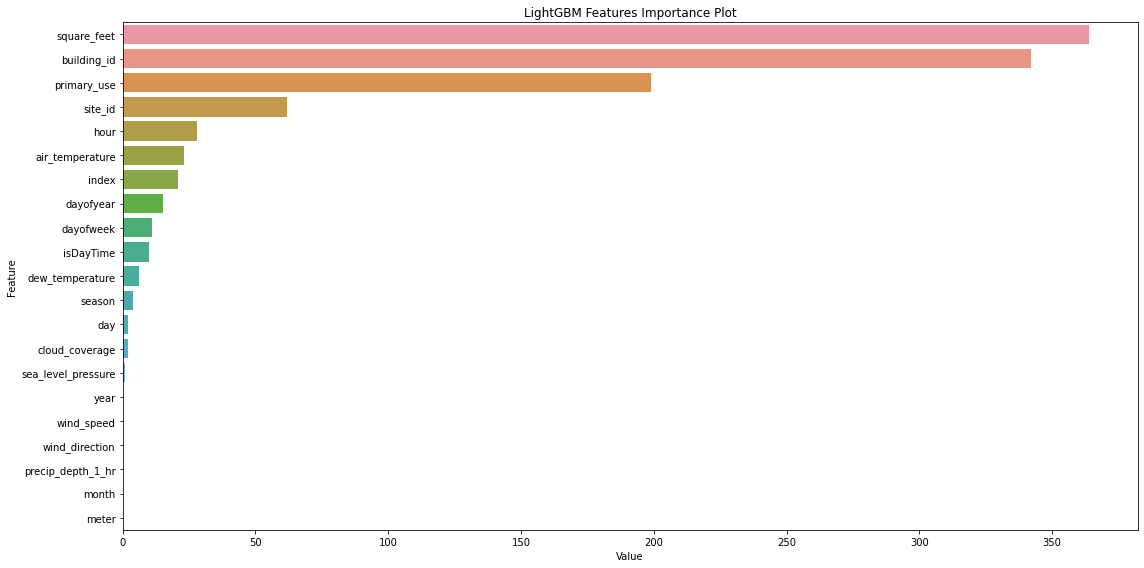

In [30]:
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(), gbm.feature_name()),reverse = True), columns=['Value','Feature'])

plt.figure(figsize=(16, 8))

sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))

plt.title('LightGBM Features Importance Plot')

plt.tight_layout()

plt.show()

**Removing the Least Important features as Indicated by the Feature Selection Method**

In [37]:
new_data = reduced_train_data[['square_feet','building_id','primary_use','site_id','hour','air_temperature','index','dayofyear','dayofweek','isDayTime','dew_temperature','meter_reading']]

**Creating a Heatmap to See the Correlated Features in the New Data**

Text(0.5, 1.0, 'Correlation Matrix')

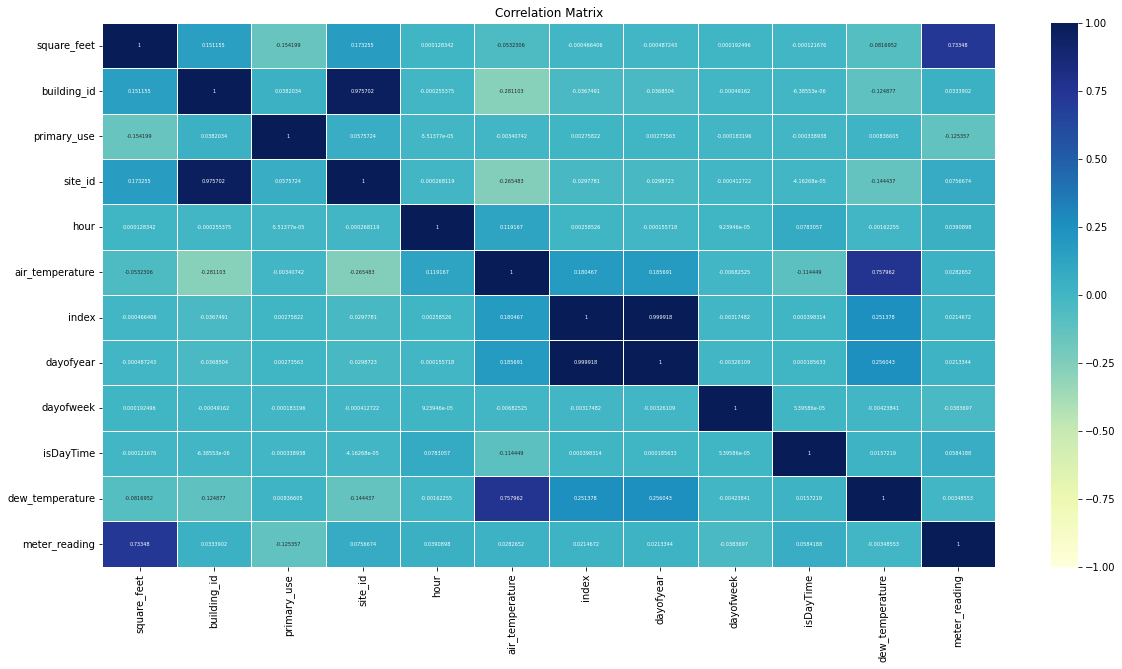

In [38]:
fig, ax = plt.subplots(figsize=(20,10)) 

sns.heatmap(new_data.corr(), annot=True, vmin = -1,vmax = 1,linewidths = 1,annot_kws={"size": 5},fmt="g",ax=ax,cmap="YlGnBu").set_title('Correlation Matrix')

**Removing Highly Correlated Features**

In [39]:
new_data.drop(['site_id','dew_temperature'],axis = 1,inplace=True)

**Creating another Heatmap to Verify that there are no Further Improvements to be Done**

Text(0.5, 1.0, 'Correlation Matrix')

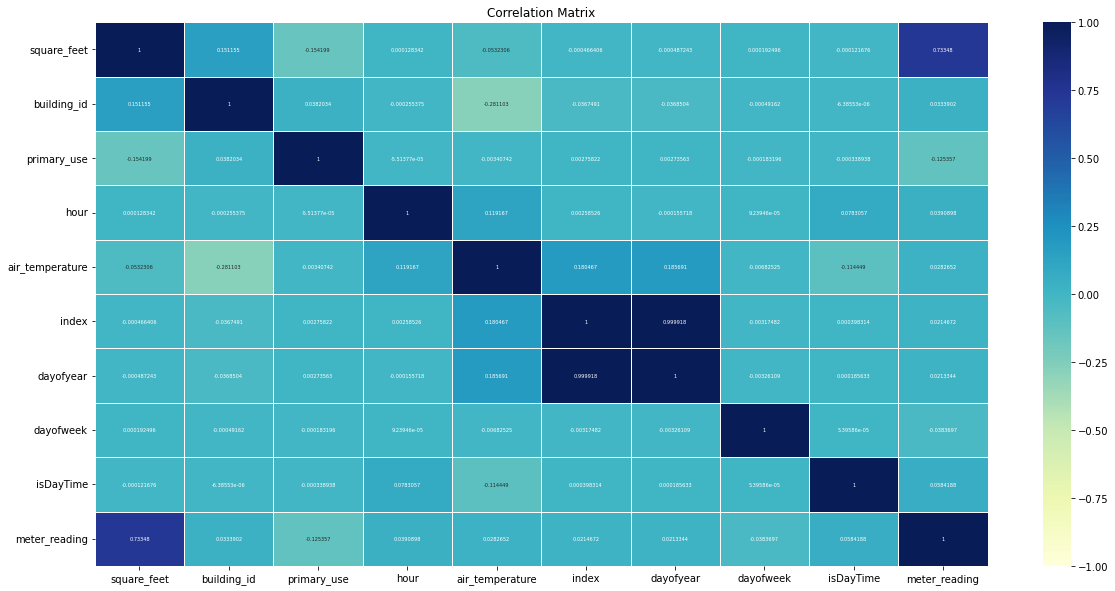

In [40]:
fig, ax = plt.subplots(figsize=(20,10)) 

sns.heatmap(new_data.corr(), annot=True, vmin = -1,vmax = 1,linewidths=1,annot_kws={"size": 5},fmt="g",ax=ax,cmap="YlGnBu").set_title('Correlation Matrix')